In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
datos, metadatos = tfds.load("mnist", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incompleteL6YG3R',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

In [4]:
datos_entrenamiento = datos["train"]
datos_pruebas = datos["test"]

In [5]:
nombres_clases = metadatos.features["label"].names

In [6]:
#Normalizacion
#0-255 1 byte
#Transformar 0-255 0-1 (0=0, 255=1, 127=.5)

#Normalizar datos ent y pruebas con una funcion
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes = imagenes/255
  return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar en cache
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

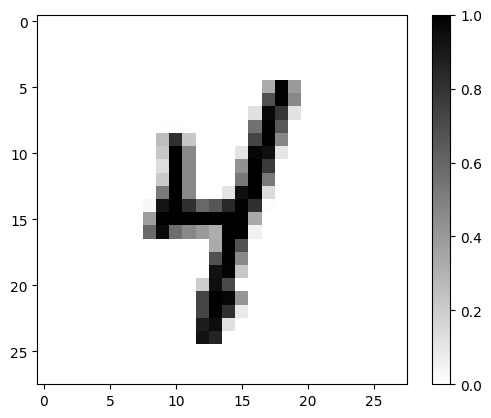

In [7]:
for imagen, etiqueta in datos_entrenamiento.take(1):
  break

import matplotlib.pyplot as plt

#Mostrarlo en pantalla
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

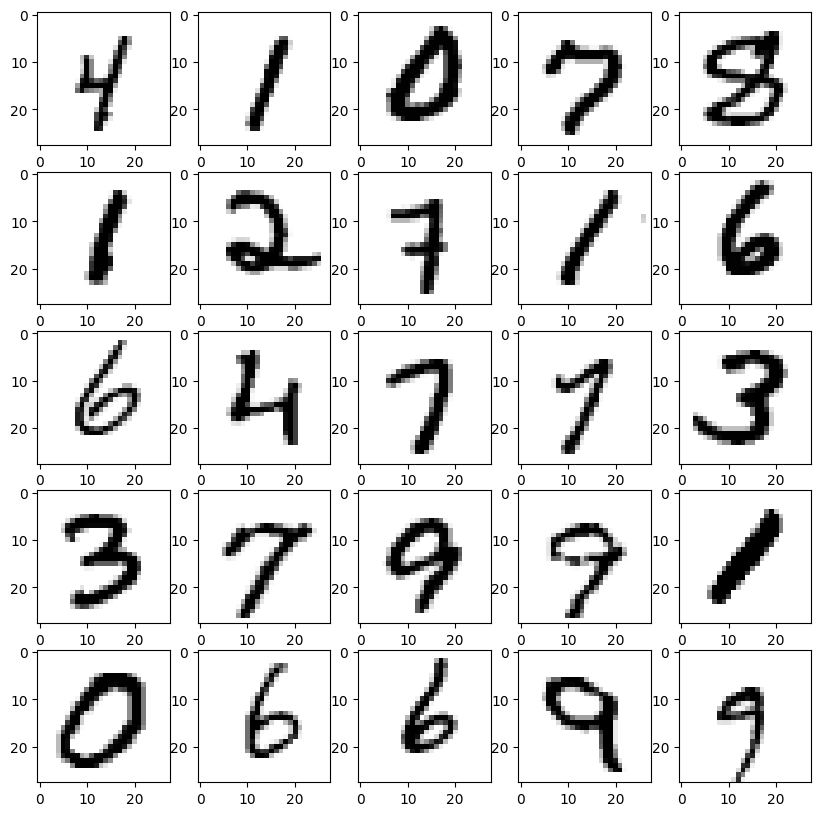

In [8]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  #Mostrarlo en pantalla
  plt.subplot(5, 5, i+1)
  plt.imshow(imagen, cmap=plt.cm.binary)

plt.show()

In [9]:
modelo = tf.keras.Sequential([
    #784 datos de entrada
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 = blanco y negro
    # # # Capa oculta
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    # Capa de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [10]:
modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [11]:
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [12]:
import math

#Entrenar
entrnamiento = modelo.fit(
    datos_entrenamiento, epochs=10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10
1875/1875 [==============================] - 14s 2ms/step - loss: 0.2938 - accuracy: 0.9160
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1362 - accuracy: 0.9590
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0994 - accuracy: 0.9697
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0785 - accuracy: 0.9759
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0646 - accuracy: 0.9797
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0572 - accuracy: 0.9819
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0480 - accuracy: 0.9851
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0445 - accuracy: 0.9860
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0397 - accuracy: 0.9872
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.03

1/1 [==============================] - 0s 105ms/step


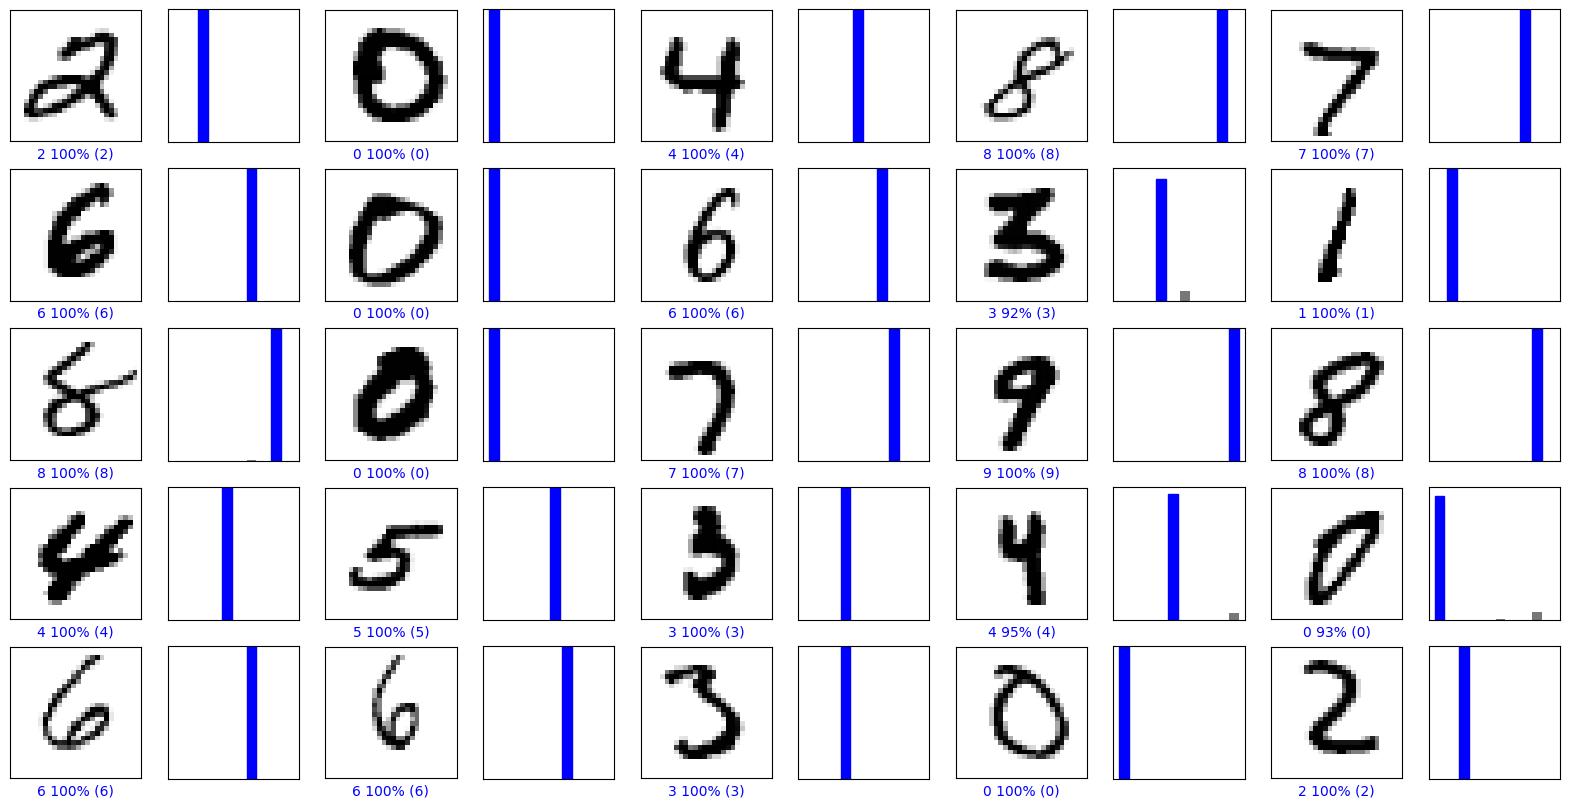

In [13]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)